# Megafon

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:
* data_train.csv: id, vas_id, buy_time, target
* features.csv.zip: id, <feature_list> 

И тестовый набор:
* data_test.csv: id, vas_id, buy_time
* target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
* buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция * datetime.fromtimestamp из модуля datetime.
* id - идентификатор абонента
* vas_id - подключаемая услуга


In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

In [2]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import joblib
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.externals.joblib import parallel_backend
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_test = pd.read_csv('/home/ksu/Documents/megafon/data_test.csv')

In [5]:
df_train = pd.read_csv('/home/ksu/Documents/megafon/data_train.csv')

In [6]:
df_features = dd.read_csv('/home/ksu/Documents/megafon/features.csv', sep='\t')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


In [9]:
users = pd.concat([df_train, df_test]).id.unique()
df_features = df_features[df_features.id.isin(users)].compute()
del users

df_features.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 831653
Строк в тесте 71231


In [11]:
df_train['target'].value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

Text(0.5, 0, 'target')

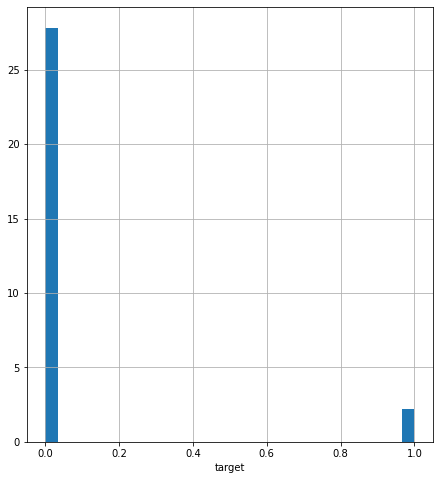

In [12]:
plt.figure(figsize = (16, 8))
plt.subplot(121)
df_train['target'].hist(density=True, bins=30)
plt.xlabel('target')

In [13]:
df_train = df_features.merge(df_train, on=['id'], how = 'inner')

In [14]:
df_features_groupby = df_features.groupby('id').first()

In [15]:
df_train = df_train.drop('buy_time_y', axis=1)

In [16]:
df_train = df_train.rename(columns={"buy_time_x": "buy_time"})

In [17]:
df_train = df_train.drop('Unnamed: 0', axis=1)

In [18]:
df_train.to_csv('/home/ksu/Documents/megafon/df_train.csv')

In [19]:
RANDOM_STATE = 200

In [20]:
def features(X: pd.DataFrame):
    
    X_nunique = X.apply(lambda x: x.nunique(dropna=False))
    
    f_init = set(X_nunique.index.tolist())
    
    f_const = set(X_nunique[X_nunique == 1].index.tolist())
    f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
    f_other = f_init - (f_numeric | f_const)
    f_binary = set(X.loc[:, f_other].columns[(
        (X.loc[:, f_other].max() == 1) & \
        (X.loc[:, f_other].min() == 0) & \
        (X.loc[:, f_other].isnull().sum() == 0)
    )])
    
    
    f_other = f_other - f_binary
    f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
    f_other = f_other - f_categorical
    f_numeric = f_numeric | f_other
    f_all = f_binary | f_categorical | f_numeric

    print('f_init:', len(f_init))
    print('f_const:', len(f_const))
    print('f_categorical:', len(f_categorical))
    print('f_numeric:', len(f_numeric))
    

    return list(f_binary), list(f_categorical), list(f_numeric), list(f_all)

In [21]:
X = df_train.drop(['id','target'], axis=1)
y = df_train['target']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100, shuffle=True, stratify=y)

In [23]:
f_binary, f_categorical, f_numeric, f_all = features(X_train)
del df_train, X, y

f_init: 255
f_const: 5
f_categorical: 1
f_numeric: 249


In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame)
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
    
        try:
                return X[self.key]
        except KeyError:
                key_error =  list(set(self.key) - set(X.key))
                raise KeyError("DataFrame missing other columns: %s" % key_error)

In [25]:
pipeline = make_pipeline(
   ColumnSelector(key=f_all),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(key =f_numeric),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(key=f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ]),
    SelectFromModel(LogisticRegression(random_state=RANDOM_STATE))
)

# Final model

In [26]:
gbc = make_pipeline(
    pipeline,
    GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        learning_rate=0.3,
        n_estimators=300,
        min_samples_split=2,
        max_depth=5,
    )
)

In [27]:
gbc.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(key=['194', '209', '12', '11',
                                                      '171', '155', '248', '84',
                                                      '216', '2', '21', '207',
                                                      '90', '148', '226', '128',
                                                      '83', '231', '121', '110',
                                                      '96', '211', '66', '44',
                                                      '77', '132', '26', '0',
                                                      '147', '190', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('columnselec...
                                                 

In [28]:
def model(gbc, X_test, y_test):
    y_test_pred = gbc.predict_proba(X_test)[:,1]
    print(f'{classification_report(y_test, y_test_pred > 0.5)}\n\n')

In [29]:
model(gbc, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    239354
         1.0       0.37      0.04      0.06     18662

    accuracy                           0.93    258016
   macro avg       0.65      0.52      0.51    258016
weighted avg       0.89      0.93      0.90    258016





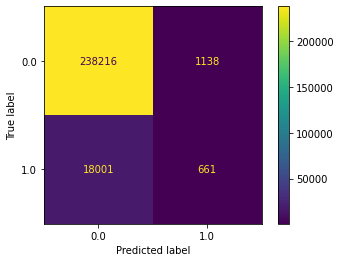

In [30]:
plot_confusion_matrix(gbc, X_test, y_test) 
plt.show()

In [31]:
y_test_pred = gbc.predict_proba(X_test)[:,1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred)
print("AUC_PR = %.3f" % auc(recall, precision))
print("AUC_ROC = %.3f" % auc(fpr, tpr))

AUC_PR = 0.327
AUC_ROC = 0.841


In [32]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

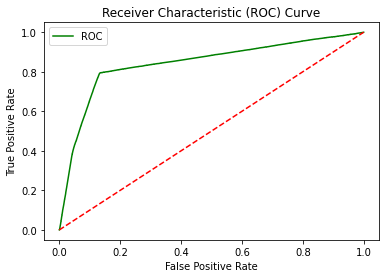

In [33]:
plot_roc_curve(fpr, tpr)

# Saving the model

In [34]:
with open('final_model.pickle', 'wb') as file:
    pickle.dump(gbc, file)